In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import cv2
import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import json
import os
import random
# bool(random.getrandbits(1))

2024-07-21 13:38:21.865959: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-21 13:38:21.948418: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-21 13:38:21.969443: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-21 13:38:22.119479: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-21 13:38:23.552376: W tensorflow/compiler/tf2

In [2]:
#importing data
classes_train = pd.read_csv('../data/train/_classes.csv')
classes_test = pd.read_csv('../data/test/_classes.csv')
classes_valid = pd.read_csv('../data/valid/_classes.csv')

pics_train = []
pics_valid = []
pics_test = []


for filename in classes_train['filename']:
    img = cv2.imread('../data/train/'+filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    pics_train.append(img)

for filename in classes_valid['filename']:
    img = cv2.imread('../data/valid/'+filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    pics_valid.append(img)

for filename in classes_test['filename']:
    img = cv2.imread('../data/test/'+filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    pics_test.append(img)


In [3]:
pics_train = np.array(pics_train)
pics_valid = np.array(pics_valid)
pics_test = np.array(pics_test)

In [4]:
def hard_crop(image):
    return image[:,:,100:image.shape[2]-100]

In [5]:
train_cropped = hard_crop(pics_train)
valid_cropped = hard_crop(pics_valid)
test_cropped = hard_crop(pics_test)

# X = np.concatenate((train_cropped, valid_cropped, test_cropped), axis=0)


In [6]:
train_img = []
valid_img = []
test_img = []

for pic in tqdm.tqdm(range(len(train_cropped))):
    img = cv2.resize(train_cropped[pic], (192, 160))
    train_img.append(img)

for pic in tqdm.tqdm(range(len(valid_cropped))):
    img = cv2.resize(valid_cropped[pic], (192, 160))
    valid_img.append(img)

for pic in tqdm.tqdm(range(len(test_cropped))):
    img = cv2.resize(test_cropped[pic], (192, 160))
    test_img.append(img)

# train_img = np.array(train_img)
# valid_img = np.array(valid_img)
# test_img = np.array(test_img)

X = np.concatenate((train_img, test_img, valid_img), axis=0)


100%|██████████| 985/985 [00:00<00:00, 23263.51it/s]


In [7]:
np.array(X)[0].shape

(160, 192)

In [8]:
all_data_merged = pd.concat([classes_train, classes_test, classes_valid])
print(all_data_merged[" DangerousDriving"].sum())
print(all_data_merged[" SafeDriving"].sum())
print(all_data_merged[" Yawn"].sum())
print(all_data_merged[" Distracted"].sum())
print(all_data_merged[" Drinking"].sum())
print(all_data_merged[" SleepyDriving"].sum())

ratio_dangerous = all_data_merged[" DangerousDriving"].sum() / all_data_merged[" SafeDriving"].sum()
ratio_yawn = all_data_merged[" Yawn"].sum() / all_data_merged[" SafeDriving"].sum()
ratio_distracted = all_data_merged[" Distracted"].sum() / all_data_merged[" SafeDriving"].sum()
ratio_drinking = all_data_merged[" Drinking"].sum() / all_data_merged[" SafeDriving"].sum()
ratio_sleepy = all_data_merged[" SleepyDriving"].sum() / all_data_merged[" SafeDriving"].sum()

pics_per_pic = [1, 11, 2, 14, 6]


4642
6180
546
2080
428
979


(160, 192)
False


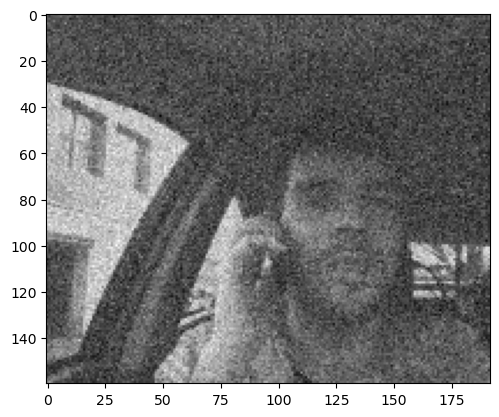

In [9]:
def add_noise(image):
    # Add Gaussian noise
    row, col = image.shape
    print(image.shape)
    mean = 0
    var = 0.1
    sigma = var**0.5
    gauss = np.random.normal(mean, sigma, (row, col))*100
    noisy_image = image + gauss
    
    # Clip the values to be in the valid range [0, 1]
    # noisy_image = np.clip(noisy_image, 0, 1)
    
    return noisy_image

test_noisy = add_noise(X[0])
plt.imshow(test_noisy, cmap='gray')
# plt.imshow(train_cropped[0], cmap='gray')
print(bool(random.getrandbits(1)))

In [10]:
#generate random number from 50 to 150
def random_number():
    return random.randint(50, 150)


In [11]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def add_noise(image, random_number):
    # Add Gaussian noise
    row, col = image.shape
    mean = 0
    var = 0.1
    sigma = var**0.5
    gauss = np.random.normal(mean, sigma, (row, col))*random_number
    noisy_image = image + gauss
    
    # Clip the values to be in the valid range [0, 1]
    # noisy_image = np.clip(noisy_image, 0, 1)
    
    return noisy_image


def augment_images(images, num_augmentations):
    """
    Augment images using ImageDataGenerator

    Args:
        images (numpy.ndarray): Images to augment
    
    Returns:
        numpy.ndarray: Augmented images
    """
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,  # Increased height shift range
        shear_range=0.3,
        zoom_range=0.3,
        vertical_flip=True,
        fill_mode='nearest'
    )
    augmented_images = []
    for image in images:
        # print('image fetched')
        # print('shape before', image.shape)
        image = np.expand_dims(image, 0)
        # print('shape after', image.shape)
        # print('image fetched')
        i = 0
        for i in range(num_augmentations):
            # print(f'loop {i} / {num_augmentations}')
            if random.choice([True, False]):
                # print('True')
                augmented_image = train_datagen.random_transform(image)
                augmented_images.append(augmented_image)
                i += 1
            else:
                # print('False')
                rand = random.randint(30, 100)
                image_n = np.squeeze(image)
                image_n = add_noise(image_n, rand)
                image_n = np.expand_dims(image_n, 0)
                augmented_images.append(image_n)
                i += 1

            if i >= num_augmentations:
                # print('breaking')
                break
    return augmented_images


# image_test = []
# for i in range(10):
#     image_test.append(augment_images([X[i]], 2))




yawn_augmented = []
yawn_data_augmented = pd.DataFrame(columns=classes_train.columns)
k = 0  # Initialize k before the loop

for i, elem in enumerate(classes_train[" Yawn"]):
    if elem == 1:
        images = augment_images([X[i]], 13)
        yawn_augmented.append(images)
        for j in range(13):
            yawn_data_augmented = pd.concat([yawn_data_augmented, classes_train.iloc[[i]]], ignore_index=True)
            yawn_data_augmented.at[k+j, "filename"] = f"{k+j}"
        k += 13  # Increment k after processing each set of images



#do same for  Distracted, Drinking and SleepyDriving
distracted_augmented = []
distracted_data_augmented = pd.DataFrame(columns=classes_train.columns)
k = 0  # Initialize k before the loop
r = 0
for i, elem in enumerate(classes_train[" Distracted"]):
    if elem == 1:
        images = augment_images([X[i]], 4)
        distracted_augmented.append(images)
        for j in range(4):
            distracted_data_augmented = pd.concat([distracted_data_augmented, classes_train.iloc[[i]]], ignore_index=True)
            distracted_data_augmented.at[k+j, "filename"] = f"{k+j}"
        k += 4  # Increment k after processing each set of images



drinking_augmented = []
drinking_data_augmented = pd.DataFrame(columns=classes_train.columns)
k = 0  # Initialize k before the loop
r = 0
for i, elem in enumerate(classes_train[" Drinking"]):
    if elem == 1:
        images = augment_images([X[i]], 18)
        drinking_augmented.append(images)
        for j in range(18):
            drinking_data_augmented = pd.concat([drinking_data_augmented, classes_train.iloc[[i]]], ignore_index=True)
            drinking_data_augmented.at[k+j, "filename"] = f"{k+j}"
        k += 18  # Increment k after processing each set of images


sleepy_augmented = []
sleepy_data_augmented = pd.DataFrame(columns=classes_train.columns)
k = 0  # Initialize k before the loop
r = 0
for i, elem in enumerate(classes_train[" SleepyDriving"]):
    if elem == 1:
        images = augment_images([X[i]], 8)
        sleepy_augmented.extend(images)
        for j in range(8):
            sleepy_data_augmented = pd.concat([sleepy_data_augmented, classes_train.iloc[[i]]], ignore_index=True)
            sleepy_data_augmented.at[k+j, "filename"] = f"{k+j}"
        k += 8  # Increment k after processing each set of images


dangerous_augmented = []
dangerous_data_augmented = pd.DataFrame(columns=classes_train.columns)
k = 0  # Initialize k before the loop
r = 0
for i, elem in enumerate(classes_train[" DangerousDriving"]):
    if elem == 1:
        images = augment_images([X[i]], 1)
        dangerous_augmented.extend(images)
        for j in range(1):
            dangerous_data_augmented = pd.concat([dangerous_data_augmented, classes_train.iloc[[i]]], ignore_index=True)
            dangerous_data_augmented.at[k+j, "filename"] = f"{k+j}"
        k += 1  # Increment k after processing each set of images





In [12]:
dangerous_augmented = np.array(dangerous_augmented).reshape(-1, 160, 192)
distracted_augmented = np.array(distracted_augmented).reshape(-1, 160, 192)
drinking_augmented = np.array(drinking_augmented).reshape(-1, 160, 192)
sleepy_augmented = np.array(sleepy_augmented).reshape(-1, 160, 192)
yawn_augmented = np.array(yawn_augmented).reshape(-1, 160, 192)

# print(dangerous_augmented.shape, distracted_augmented.shape, drinking_augmented.shape, sleepy_augmented.shape, yawn_augmented.shape)

In [13]:
#shuffle all augmented data
# np.random.shuffle(dangerous_augmented)
# np.random.shuffle(distracted_augmented)
np.random.shuffle(drinking_augmented)
np.random.shuffle(sleepy_augmented)
np.random.shuffle(yawn_augmented)

In [14]:
np.random.shuffle(dangerous_augmented)

In [15]:
np.random.shuffle(distracted_augmented)

: 

In [16]:
#augmented_fullim_1 = np.concatenate((X, dangerous_augmented[:1538], distracted_augmented[:4100], drinking_augmented[:5752], sleepy_augmented[:5201], yawn_augmented[:5634]), axis=0)
augmented_fullim_2 = np.concatenate((X[:3000], distracted_augmented[:920]), axis=0)
augmented_fullim_2 = np.concatenate((augmented_fullim_2, drinking_augmented[:2572]), axis=0)
# augmented_fullim_2 = np.concatenate((augmented_fullim_2, sleepy_augmented[:2021]), axis=0)
# augmented_fullim_2 = np.concatenate((augmented_fullim_2, yawn_augmented[:2454]), axis=0)

In [ ]:
augmented_fullim_2 = np.concatenate((augmented_fullim_2, sleepy_augmented[:2021]), axis=0)
augmented_fullim_2 = np.concatenate((augmented_fullim_2, yawn_augmented[:2454]), axis=0)

In [ ]:
# labels_fullim_1 = pd.concat([
#     all_data_merged,  # Original data labels
#     dangerous_data_augmented[:1538], 
#     distracted_data_augmented[:4100], 
#     drinking_data_augmented[:5752], 
#     sleepy_data_augmented[:5201], 
#     yawn_data_augmented[:5634]
# ], ignore_index=True)

labels_fullim_2 = pd.concat([
    all_data_merged[:3000],  # Original data labels
    distracted_data_augmented[:920], 
    drinking_data_augmented[:2572], 
    sleepy_data_augmented[:2021], 
    yawn_data_augmented[:2454]
], ignore_index=True)


In [ ]:
# permutation = np.random.permutation(len(augmented_fullim_1))
permutation2 = np.random.permutation(len(augmented_fullim_2))


In [ ]:
# augmented_fullim_1_shuffled = augmented_fullim_1[permutation]
augmented_fullim_2_shuffled = augmented_fullim_2[permutation2]

In [ ]:
# labels_fullim_1_shuffled = labels_fullim_1.iloc[permutation].reset_index(drop=True)
labels_fullim_2_shuffled = labels_fullim_2.iloc[permutation2].reset_index(drop=True)


In [ ]:
# augmented_fullim_1_shuffled = augmented_fullim_1_shuffled.tolist()
# data_aug_v1 = os.path.join('../data/', 'data_aug_v1.json')

In [ ]:
augmented_fullim_2_shuffled = augmented_fullim_2_shuffled.tolist()
data_aug_v2 = os.path.join('../data/', 'data_aug_v2.json')

In [ ]:
# with open(data_aug_v1, 'w') as f:
#     json.dump(augmented_fullim_1_shuffled, f)

# labels_fullim_1_shuffled.to_csv('../data/labels_aug_v1.csv', index=False)


In [ ]:
with open(data_aug_v2, 'w') as f:
    json.dump(augmented_fullim_2_shuffled, f)

labels_fullim_2_shuffled.to_csv('../data/labels_aug_v2.csv', index=False)

In [ ]:
# train_img = []
# valid_img = []
# test_img = []

# for pic in tqdm.tqdm(range(len(train_cropped))):
#     img = cv2.resize(train_cropped[pic], (192, 160))
#     train_img.append(img)

# for pic in tqdm.tqdm(range(len(valid_cropped))):
#     img = cv2.resize(valid_cropped[pic], (192, 160))
#     valid_img.append(img)

# for pic in tqdm.tqdm(range(len(test_cropped))):
#     img = cv2.resize(test_cropped[pic], (192, 160))
#     test_img.append(img)

# train_img = np.array(train_img)
# valid_img = np.array(valid_img)
# test_img = np.array(test_img)

In [ ]:
# train_img_aug = train_img_aug.tolist()
# valid_img_aug = valid_img_aug.tolist()
# test_img_aug = test_img_aug.tolist()

# json_train_aug = os.path.join('../data/augmented_data', 'train.json')
# json_valid_aug = os.path.join('../data/augmented_data', 'valid.json')
# json_test_aug =  os.path.join('../data/augmented_data', 'test.json')

# # file_path = os.path.join('data', 'array.json')

# with open(json_train_aug, 'w') as f:
#     json.dump(train_img_aug, f)

# with open(json_valid_aug, 'w') as f:
#     json.dump(valid_img_aug, f)

# with open(json_test_aug, 'w') as f:
#     json.dump(test_img_aug, f)

In [ ]:
#safe the augmented dataframes
# data_aug.to_csv('../data/augmented_data/train.csv', index=False)

In [ ]:
# plt.imshow(test_img[34], cmap='gray')

In [ ]:


# train_img = train_img.tolist()
# valid_img = valid_img.tolist()
# test_img = test_img.tolist()

# json_train = os.path.join('../data', 'train.json')
# json_valid = os.path.join('../data', 'valid.json')
# json_test =  os.path.join('../data', 'test.json')

# # file_path = os.path.join('data', 'array.json')

# with open(json_train, 'w') as f:
#     json.dump(train_img, f)

# with open(json_valid, 'w') as f:
#     json.dump(valid_img, f)

# with open(json_test, 'w') as f:
#     json.dump(test_img, f)